In [1]:
%reset -sf

from time import time
time_start = time()

import pandas as pd
import numpy as np
import get_data as gd
import atlas_plot as ap
import gc

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(tf.config.list_physical_devices())
print()

2023-11-25 05:42:02.599672: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.13.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]



In [2]:
np.random.seed(42)  # set random seed
sampling = int(1e5)
processor = gd.DataProcessor(sampling=sampling, processor=10)
path = "/root/work/truth/signal/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 10

['/root/work/truth/signal/CGLMP.npz', '/root/work/truth/signal/Higgs.npz', '/root/work/truth/signal/LeadLepton.npz', '/root/work/truth/signal/LeptonM.npz', '/root/work/truth/signal/LeptonP.npz', '/root/work/truth/signal/LmNu.npz', '/root/work/truth/signal/LpNu.npz', '/root/work/truth/signal/MET.npz', '/root/work/truth/signal/WmBoson.npz', '/root/work/truth/signal/WpBoson.npz', '/root/work/truth/signal/diLepton.npz', '/root/work/truth/signal/subLeadLepton.npz', '/root/work/truth/signal/xi_xyz.npz']



In [3]:
GEV = 1e3

cut_pre_pt_lead = data.LeadLep["pt"] > 22 * GEV
cut_pre_pt_sub = data.SubLep["pt"] > 15 * GEV
cut_pre_dilep_m = data.diLep["m"] > 10 * GEV
cut_pre_pt_miss = data.MET["pt"] > 20 * GEV
cut_pre = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss

del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

In [4]:
# y -> observed params
lep_p = processor.process_part(data.LepP)[cut_pre]
lep_m = processor.process_part(data.LepM)[cut_pre]
lep_kin = pd.concat([lep_p, lep_m], axis=1)
MET = processor.process_MET(data.MET).iloc[:, 1:3][cut_pre]
MET_kin = pd.concat([MET, lep_kin], axis=1)
print("MET_kin shape:", MET_kin.shape)
print(MET_kin.head(3))
print()

# x -> interested unknowns
dinu_kin = pd.DataFrame(processor.process_dipart(data.LepP, data.LepM)["E"][cut_pre])
print("dinu_kin shape:", dinu_kin.shape)
print(dinu_kin.head(3))
print()

del (processor, lep_p, lep_m, MET)
gc.collect()

MET_kin shape: (47089, 10)
      MET_px     MET_py           E        px         py         pz  \
2  16.800106 -30.457136   27.938791  4.063994  13.764582 -95.239852   
3 -24.448158 -12.000150   39.585180  7.269995  81.570773  35.825145   
4 -41.983970 -15.922710  196.946359  8.435738  -2.516708 -76.383867   

            E         px         py          pz  
2   81.878680 -67.647688  34.348543  -80.730063  
3   38.543746  24.098484   7.282697  376.069875  
4  585.067500  36.725297  18.096498  -68.565711  

dinu_kin shape: (47089, 1)
            E
2  109.817471
3   78.128926
4  782.013859



20

In [5]:
from sklearn.preprocessing import StandardScaler

SCALAR_int = StandardScaler()
norm_var = SCALAR_int.fit_transform(dinu_kin)
dinu_kin = norm_var

SCALAR_MET = StandardScaler()
norm_var = SCALAR_MET.fit_transform(MET_kin)
MET_kin = norm_var

del norm_var

from sklearn.model_selection import train_test_split

indices_arr = np.arange(dinu_kin.shape[0], dtype="int")
indices_arr = np.random.choice(indices_arr, sampling)
train_indices, temp_indices = train_test_split(
    indices_arr.flatten(), train_size=0.8, test_size=0.2, random_state=42
)
valid_indices, test_indices = train_test_split(
    temp_indices, train_size=0.5, test_size=0.5, random_state=42
)

train_x = dinu_kin[train_indices]
valid_x = dinu_kin[valid_indices]
test_x = dinu_kin[test_indices]
train_y = MET_kin[train_indices]
valid_y = MET_kin[valid_indices]
test_y = MET_kin[test_indices]

print(
    f"X (Interest)\nTraining data shape: {train_x.shape};\nValiding data shape: {valid_x.shape};\nTesting data shape: {test_x.shape}."
)
print(
    f"Y (Observed)\nTraining data shape: {train_y.shape};\nValiding data shape: {valid_y.shape};\nTesting data shape: {test_y.shape}."
)
print()

X (Interest)
Training data shape: (80000, 1);
Validing data shape: (10000, 1);
Testing data shape: (10000, 1).
Y (Observed)
Training data shape: (80000, 10);
Validing data shape: (10000, 10);
Testing data shape: (10000, 10).



In [6]:
def build_model():
    model = keras.models.Sequential()

    # encoder
    model.add(layers.Flatten(input_shape=(train_y.shape[-1],)))
    # model.add(layers.Dense(units=8, activation="relu"))
    model.add(layers.Dense(units=4, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    # bottleneck
    model.add(layers.Dense(units=2, activation="relu"))
    # decoder
    model.add(layers.Dense(units=4, activation="relu"))
    model.add(layers.Dense(units=8, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Last dense layers
    model.add(layers.Dense(units=1, activation="linear"))

    # Compile model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss="mse")
    model.summary()

    return model

In [7]:
model = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 4)                 44        
                                                                 
 batch_normalization (Batch  (None, 4)                 16        
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 4)                 0         
                                                                 
 dense_1 (Dense)             (None, 2)                 10        
                                                                 
 dense_2 (Dense)             (None, 4)                 12        
                                                        

2023-11-25 05:42:07.350332: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46696 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2023-11-25 05:42:07.351069: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46696 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


In [8]:
# Load the TensorBoard notebook extension.
import datetime

# set log file
%rm -r ./logs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# set callback of tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=5, write_graph=True, write_images=False,)

stop_early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-6,
    patience=10,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# Fit the model
history = model.fit(
    x=train_y,
    y=train_x,
    validation_data=(valid_y, valid_x),
    epochs=512,
    batch_size=256,
    verbose=2,
    callbacks=[stop_early, tensorboard_callback],
)

Epoch 1/512


2023-11-25 05:42:09.909307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-25 05:42:09.913892: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x560e0a57eea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-25 05:42:09.913950: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-25 05:42:09.913963: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-25 05:42:09.924018: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-25 05:42:10.062736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-25 05:42:10.18880

313/313 - 5s - loss: 0.9553 - val_loss: 0.8316 - 5s/epoch - 16ms/step
Epoch 2/512
313/313 - 2s - loss: 0.7549 - val_loss: 0.6515 - 2s/epoch - 5ms/step
Epoch 3/512
313/313 - 2s - loss: 0.5937 - val_loss: 0.4966 - 2s/epoch - 5ms/step
Epoch 4/512
313/313 - 2s - loss: 0.4586 - val_loss: 0.3987 - 2s/epoch - 5ms/step
Epoch 5/512
313/313 - 2s - loss: 0.3719 - val_loss: 0.3285 - 2s/epoch - 5ms/step
Epoch 6/512
313/313 - 2s - loss: 0.3094 - val_loss: 0.2747 - 2s/epoch - 5ms/step
Epoch 7/512
313/313 - 2s - loss: 0.2677 - val_loss: 0.2312 - 2s/epoch - 5ms/step
Epoch 8/512
313/313 - 2s - loss: 0.2351 - val_loss: 0.1993 - 2s/epoch - 5ms/step
Epoch 9/512
313/313 - 2s - loss: 0.2012 - val_loss: 0.1587 - 2s/epoch - 5ms/step
Epoch 10/512
313/313 - 2s - loss: 0.1698 - val_loss: 0.1345 - 2s/epoch - 5ms/step
Epoch 11/512
313/313 - 2s - loss: 0.1474 - val_loss: 0.1121 - 2s/epoch - 5ms/step
Epoch 12/512
313/313 - 2s - loss: 0.1267 - val_loss: 0.0938 - 2s/epoch - 5ms/step
Epoch 13/512
313/313 - 2s - loss: 0.

In [9]:
# save model
model.save('AE_e.h5')
# predict
x_pred = model.predict(test_y)
sig_pred = x_pred.flatten()
sig_truth = test_x.flatten()

  1/313 [..............................] - ETA: 34s

/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 1s 1ms/step


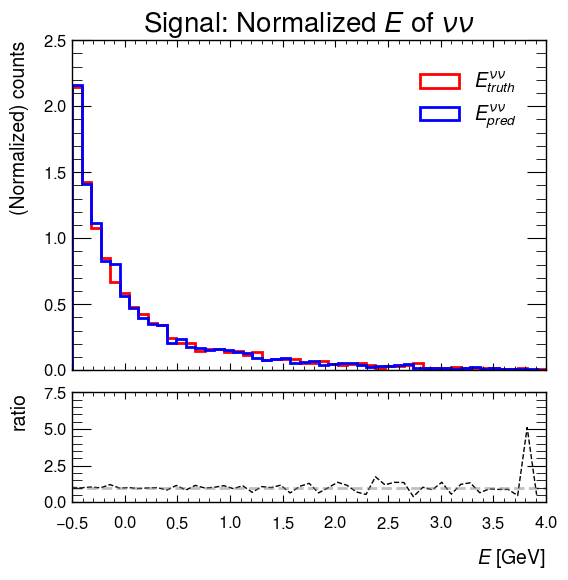

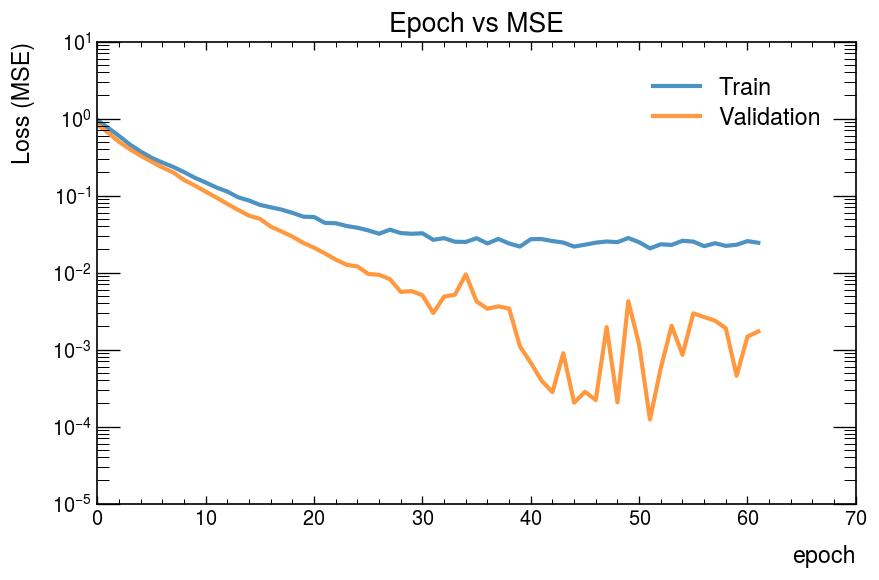

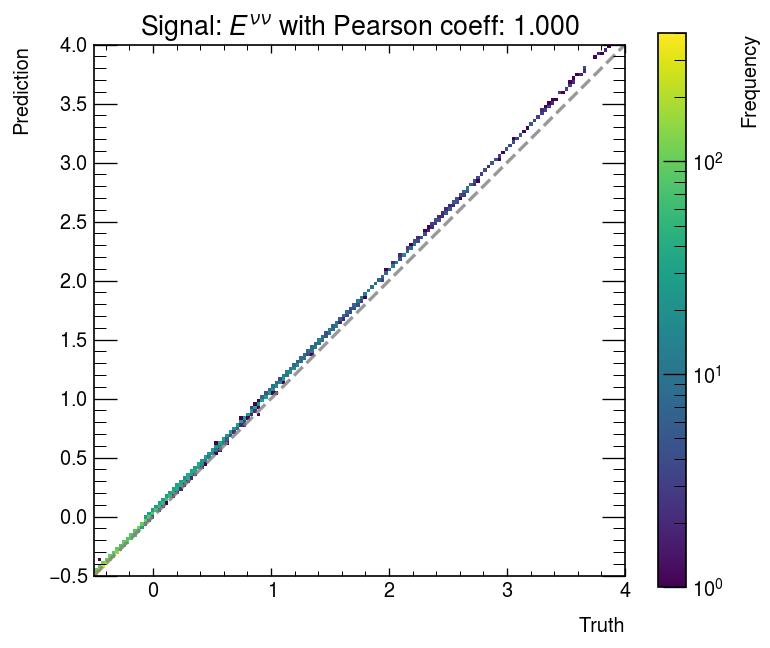

In [10]:
import scipy as sp

plot = ap.Plotter()
range = [-0.5, 4]

plot.plot_hist(
    [sig_truth, sig_pred],
    [r"$E_{truth}^{\nu\nu}$", r"$E_{pred}^{\nu\nu}$"],
    r"Signal: Normalized $E$ of $\nu\nu$",
    range=range,
    xlabel=r"$E$ [GeV]",
)

plot.plot_loss_history(history, logy=True)

plot.plot_2d_histogram(
    sig_pred,
    sig_truth,
    "Signal: "
    + r"$E^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(sig_truth, sig_pred)[0]:.3f}",
    range=range,
)

In [11]:
# Background

processor = gd.DataProcessor(sampling=sampling, processor=10)
path = "/root/work/truth/background/*npz"
processor.load_files(path)
data = gd.Data(*processor.files)
# print(dir(data))

Number of available processors: 128
Number of used processors: 10

['/root/work/truth/background/CGLMP.npz', '/root/work/truth/background/Higgs.npz', '/root/work/truth/background/LeadLepton.npz', '/root/work/truth/background/LeptonM.npz', '/root/work/truth/background/LeptonP.npz', '/root/work/truth/background/LmNu.npz', '/root/work/truth/background/LpNu.npz', '/root/work/truth/background/MET.npz', '/root/work/truth/background/WmBoson.npz', '/root/work/truth/background/WpBoson.npz', '/root/work/truth/background/diLepton.npz', '/root/work/truth/background/subLeadLepton.npz', '/root/work/truth/background/xi_xyz.npz']



In [12]:
# y -> observed params
lep_p = processor.process_part(data.LepP)[cut_pre]
lep_m = processor.process_part(data.LepM)[cut_pre]
lep_kin = pd.concat([lep_p, lep_m], axis=1)
MET = processor.process_MET(data.MET).iloc[:, 1:3][cut_pre]
MET_kin = pd.concat([MET, lep_kin], axis=1)
print("MET_kin shape:", MET_kin.shape)
print(MET_kin.head(3))
print()

# x -> interested unknowns
dinu_kin = pd.DataFrame(processor.process_dipart(data.LepP, data.LepM)["E"][cut_pre])
print("dinu_kin shape:", dinu_kin.shape)
print(dinu_kin.head(3))
print()

del (processor, lep_p, lep_m, MET)
gc.collect()

MET_kin shape: (47089, 10)
      MET_px     MET_py          E         px         py         pz  \
2  12.542417  29.573581  47.815059 -21.315428  45.633828  -9.166943   
3 -28.046018 -45.255130  43.335184  30.948270 -12.014405 -59.042395   
4  -6.118746 -43.808047  31.977082  41.501539 -72.848164  65.469578   

            E         px         py          pz  
2   17.210883  20.278842  -5.134687   48.637703  
3  181.251000  -5.289632  10.576978 -406.692406  
4   30.541406 -21.632902 -12.714723  -71.628742  

dinu_kin shape: (47089, 1)
            E
2   65.025941
3  224.586184
4   62.518488



35045

In [13]:
SCALAR_int_bkg = StandardScaler()
norm_var = SCALAR_int.fit_transform(dinu_kin)
dinu_kin = norm_var

SCALAR_MET_bkg = StandardScaler()
norm_var = SCALAR_MET.fit_transform(MET_kin)
MET_kin = norm_var

del norm_var

x, y = dinu_kin[indices_arr], MET_kin[indices_arr]

print(f"X (Interest) data shape: {x.shape};\nY (Observed) data shape: {y.shape}.")
print()

X (Interest) data shape: (100000, 1);
Y (Observed) data shape: (100000, 10).



In [14]:
x_pred = model.predict(y)
bkg_pred = x_pred.flatten()
bkg_truth = x.flatten()

  31/3125 [..............................] - ETA: 5s  

3125/3125 [==============================] - 5s 1ms/step


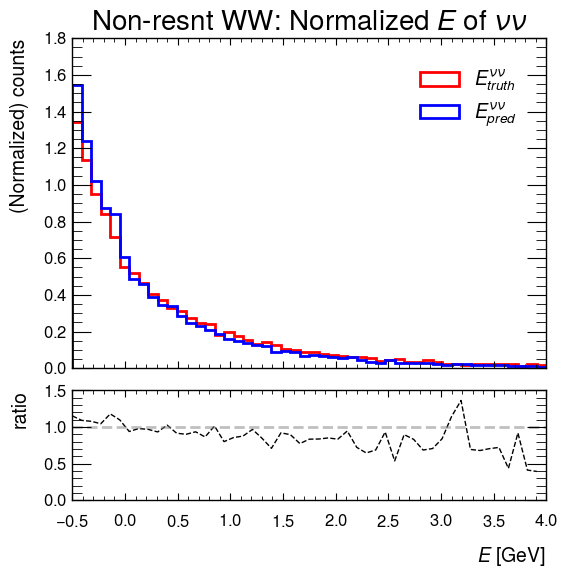

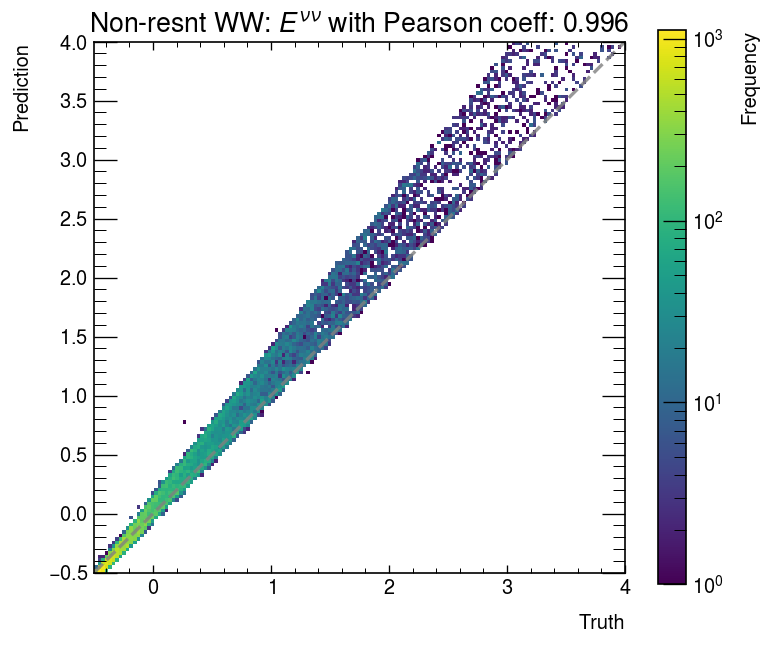

Time cost: 126.95 s.


In [15]:
plot = ap.Plotter()

range = [-0.5, 4]

plot.plot_hist(
    [bkg_truth, bkg_pred],
    [r"$E_{truth}^{\nu\nu}$", r"$E_{pred}^{\nu\nu}$"],
    "Non-resnt WW: " + r"Normalized $E$ of $\nu\nu$",
    range=range,
    xlabel=r"$E$ [GeV]",
)

plot.plot_2d_histogram(
    bkg_pred,
    bkg_truth,
    "Non-resnt WW: "
    + r"$E^{\nu\nu}$ "
    + f"with Pearson coeff: {sp.stats.pearsonr(bkg_truth, bkg_pred)[0]:.3f}",
    range=range,
)

time_end = time()
print(f"Time cost: {(time_end - time_start):.2f} s.")